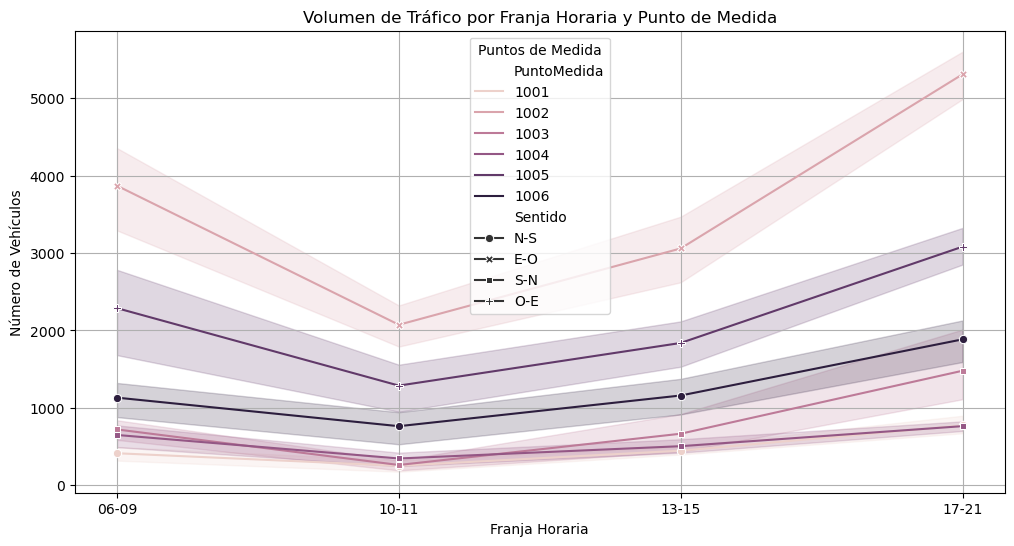

Archivo guardado en: C:\Users\AMIM GTAC\Downloads\resultados.xlsx


In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de conexión a SQL Server
server = 'sqltransit'
database = 'qgis_dt'
username = 'sa'
password = 'Etra-3000'
engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=SQL+Server')

# Lista de puntos de medida a incluir
puntos_medida = ('1003', '1004', '1005', '1006', '1001', '1002')

# Definir rango de fechas
fecha_inicio = '2025-02-24'
fecha_fin = '2025-03-3'

# Consulta SQL para obtener datos de tráfico
query_datos = f'''
SELECT 
    DATEPART(DAY, [Time]) AS Dia,
    DATEPART(HOUR, [Time]) AS Hora,
    [PuntoMedida],
    [Sentido],
    SUM([Intensidad]) AS Volumen
FROM [QGIS_DT].[dbo].[vw_dt_stu_espiras_15mnts]
WHERE DATEPART(HOUR, [Time]) IN (6,7,8,9,10,11,13,14,15,17,18,19,20,21)
AND [PuntoMedida] IN {puntos_medida}
AND [Time] BETWEEN '{fecha_inicio}' AND '{fecha_fin}'
GROUP BY DATEPART(DAY, [Time]), DATEPART(HOUR, [Time]), [PuntoMedida], [Sentido]
ORDER BY [PuntoMedida], [Dia], [Hora], [Sentido]
'''

# Consulta SQL para obtener detalles adicionales de los puntos de medida
query_catalogo = '''
SELECT [PuntoMedida], [Descripcion], [cruce], [IdSubarea]
FROM [Aforados].[dbo].[Vw_Catalogo_SMM]
WHERE [PuntoMedida] IN ''' + str(puntos_medida) + '''
'''

# Conectar a la base de datos y leer los datos
def obtener_datos():
    with engine.connect() as conn:
        df_datos = pd.read_sql(query_datos, conn)
        df_catalogo = pd.read_sql(query_catalogo, conn)
    
    # Unir los datos de tráfico con el catálogo
    df_merged = df_datos.merge(df_catalogo, on='PuntoMedida', how='left')
    return df_merged

# Función para procesar los datos
def procesar_datos(df):
    franjas_horarias = {
        '06-09': [6, 7, 8, 9],
        '10-11': [10, 11],
        '13-15': [13, 14, 15],
        '17-21': [17, 18, 19, 20, 21]
    }
    
    resultados = []
    for franja, horas in franjas_horarias.items():
        df_franja = df[df['Hora'].isin(horas)]
        df_franja = df_franja.groupby(['PuntoMedida', 'Sentido', 'Dia']).agg({'Volumen': 'sum'}).reset_index()
        df_franja['FranjaHoraria'] = franja
        resultados.append(df_franja)
    
    return pd.concat(resultados, ignore_index=True)

# Función para generar gráficos
def generar_graficos(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='FranjaHoraria', y='Volumen', hue='PuntoMedida', style='Sentido', markers=True, dashes=False)
    plt.title("Volumen de Tráfico por Franja Horaria y Punto de Medida")
    plt.xlabel("Franja Horaria")
    plt.ylabel("Número de Vehículos")
    plt.legend(title="Puntos de Medida")
    plt.grid()
    plt.show()

# Función para guardar resultados en Excel
def guardar_resultados(df, ruta_salida):
    df.to_excel(ruta_salida, index=False)
    print(f"Archivo guardado en: {ruta_salida}")

# Ejecución principal
if __name__ == "__main__":
    ruta_salida = r"C:\Users\AMIM GTAC\Downloads\resultados.xlsx"

    
    datos = obtener_datos()
    datos_procesados = procesar_datos(datos)
    generar_graficos(datos_procesados)
    guardar_resultados(datos_procesados, ruta_salida)
